# 스테이블디퓨전으로_이미지_생성_서비스만들기
* 간단한 스케치를 기반으로 이미지 생성
* 스케치가 되어있는 이미지를 업로드해서 생성


### Stable Diffusion
스테이블 디퓨전(Stable Diffusion)은 텍스트에서 이미지를 생성하는 인공지능(AI) 모델이다. 사용자가 입력한 텍스트 설명을 기반으로 고화질 이미지를 만들어내는 기능을 제공한다. 이 모델은 딥러닝 기법을 사용하여 훈련되었으며, 다양한 종류의 이미지 생성 작업에서 매우 강력한 성능을 발휘한다.


In [1]:
#!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 26.6 MB/s eta 0:00:00


In [18]:
import os
import torch
from typing import IO
import gradio as gr
import requests
from tqdm import tqdm
from PIL import Image
from diffusers import StableDiffusionImg2ImgPipeline

# 스케치 투 이미지 생성 UI 구현하기

In [2]:
WIDTH = 512
HEIGHT = 512


with gr.Blocks() as app:
    gr.Markdown("## 프롬프트 입력")
    with gr.Row():
        prompt = gr.Textbox(label="Prompt")
    with gr.Row():
        n_promt = gr.Textbox(label="Negative Prompt")
    
    gr.Markdown("## 스케치 to 이미지 생성")
    with gr.Row():
        with gr.Column():
            with gr.Tab("Canvas"):
                with gr.Row():
                    canvas = gr.Image(
                        label = "Draw",
                        source = "canvas",
                        image_mode = 'RGB',
                        tool = 'color-sketch',
                        interactive = True,
                        width = WIDTH, 
                        height = HEIGHT, 
                        shape = (WIDTH, HEIGHT), 
                        brush_radius = 20,
                        type = 'pil'
                    )         
                with gr.Row():
                    canvas_run_btn = gr.Button(value = "Generate")
            
            with gr.Tab("File"):
                with gr.Row():
                    file = gr.Image(
                        label = "Upload",
                        source = "upload",
                        image_mode = 'RGB',
                        tool = 'color-sketch',
                        interactive = True,
                        width = WIDTH, 
                        height = HEIGHT, 
                        shape = (WIDTH, HEIGHT), 
                        type = 'pil'
                    )
                with gr.Row():
                    file_run_btn = gr.Button(value = "Generate")
        

IMPORTANT: You are using gradio version 3.40.0, however version 4.29.0 is available, please upgrade.
--------


In [7]:
app.launch(inline=False, share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://5288f33446ff932123.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [26]:
app.close()

Closing server running on port: 7861


# 모델 다운로드 UI 구현하기

In [4]:
with gr.Blocks() as app:
    gr.Markdown("## 모델 다운로드")
    with gr.Row():
        model_url = gr.Textbox(label = "모델 URL", placeholder = "https://civitai.com/")
        download_model_btn = gr.Button(value = "모델 다운로드")
    with gr.Row():
        model_file = gr.File(label = "모델 파일")
        
    download_model_btn.click(
        download_model,
        [model_url],
        [model_file]
    )
        

IMPORTANT: You are using gradio version 3.40.0, however version 4.29.0 is available, please upgrade.
--------


In [5]:
app.launch(inline=False, share=True)

Running on local URL:  http://127.0.0.1:7860

Thanks for being a Gradio user! If you have questions or feedback, please join our Discord server and chat with us: https://discord.gg/feTf9x3ZSB
Running on public URL: https://8a96d67fc0075cbc84.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [30]:
app.close()

models/disneyPixarCartoon_v10.safetensors: 100%|██████████████████████████████████| 3.95G/3.95G [11:55<00:00, 5.93MiB/s]


[INFO] File downloaded: models/disneyPixarCartoon_v10.safetensors
Closing server running on port: 7861


# 모델 다운로드 기능 구현하기

In [3]:
import os
import glob  # 디렉토리 안에 있는 모든 파일명을 리스트로 만들어주는 라이브러리


# 전역변수로 모델 경로와 파일명을 저장
MODEL_PATH = None 

# URL로부터 파일 다운로드 함수
def download_from_url(url, file_path, chunk_size=1024):
    try:
        resp = requests.get(url, stream = True)
        resp.raise_for_status()
    except Exception as e:
        print(f"[Error] {e}")
        raise e 
    
    total = int(resp.headers.get('content-length', 0))  # 파일 크기 추출
    with open(file_path, 'wb') as file, tqdm(desc=file_path, total=total, unit='iB', unit_scale=True, 
                                            unit_divisor = 1024) as bar:
        for data in resp.iter_content(chunk_size=chunk_size):
            size = file.write(data)
            bar.update(size)
    

# 모델을 다운로드하고 경로를 기억하는 함수
def download_model(url: str) -> str: 
    global MODEL_PATH    # 전역 변수를 사용해서 경로를 파악
    
    model_id = url.replace("https://civitai.com/models/", "").split("/")[0]
    
    try:
        response = requests.get(f"https://civitai.com/api/v1/models/{model_id}", timeout = 6000)
    except Exception as e:
        print(f"[Error] {e}")
        raise e
        
    download_url = response.json()['modelVersions'][0]['downloadUrl']
    filename = response.json()['modelVersions'][0]['files'][0]['name']

    file_path = f"models/{filename}"
    if os.path.exists(file_path):
        print(f"[INFO] File already exists: {file_path}")
        MODEL_PATH = file_path   # 모델 경로 기억
        return file_path 
    
    os.makedirs("models", exist_ok = True)
    download_from_url(download_url, file_path)
    print(f"[INFO] File downloaded: {file_path}")
    
    # 모델 경로 기억
    MODEL_PATH = file_path
    return file_path
    
    
# ./models 폴더에서 가장 최근에 수정된 모델 파일 찾기
def find_latest_model_in_directory(directory):
    model_files = glob.glob(f"{directory}/*.safetensors")
    if not model_files:
        return None
    
    
    #  가장 최근에 수정된 모델 파일 선택 
    latest_model = max(model_files, key =os.path.getmtime)
    return latest_model

### model_id = url.replace("https://civitai.com/models/", "").split("/")[0]  <br>
* 이 코드의 뜻 : <br>

https://civitai.com/models/684646/lyhanimeflux  이 URL 에서 분해하는데,  <br>
models/_______ 뒤 숫자를 추출해 model_id 에 저장한다. <br><br>
 
즉,  <br>

684646 이 숫자만 뽑아내기 위한 코드다. 

https://civitai.com/models/65203/disney-pixar-cartoon-type-a

# 다운로드한 모델 불러와서 초기화하기

In [22]:
def init_pipeline():
    global MODEL_PATH 
    
    if MODEL_PATH is None:
        MODEL_PATH = find_latest_model_in_directory("./models")
    if MODEL_PATH is None:   
        return "Error: No model found in ./models"
    
    global PIPELINE
    
    try:
        PIPELINE = StableDiffusionImg2ImgPipeline.from_single_file(
                MODEL_PATH,
                torch_dtype = torch.float16,
                variant = "fp16",
                use_safetensors = True,
        ).to('cpu')
        print("[INFO] Initialized pipeline")
        return "Model Loaded!"
    except Exception as e:
        print(f"[Error] {e}")
        

In [23]:
with gr.Blocks() as app:
    gr.Markdown("## 모델 불러오기")
    with gr.Row():
        load_model_btn = gr.Button(value="모델 불러오기")
    with gr.Row():
        is_model_check = gr.Textbox(label="Model Load Check", value="Model Not Loaded")
        
    load_model_btn.click(
        init_pipeline,
        None,
        [is_model_check]
    )

IMPORTANT: You are using gradio version 3.40.0, however version 4.29.0 is available, please upgrade.
--------


In [24]:
app.launch(inline=False, share=True)

Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://6ef19dd07ec3c292db.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/796 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/756 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/user/miniforge3/envs/torch/lib/python3.11/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint were not used when initializing CLIPTextModel: 
 ['text_model.embeddings.position_ids']
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information

[INFO] Initialized pipeline


In [25]:
app.close()

Closing server running on port: 7862


# 스케치 투 이미지 생성기능 구현

In [ ]:
def sketch_to_image(sketch, prompt, negative_prompt):
    global PIPELINE
    if PIPELINE is None:
        return "Error Pipeline is not initialized"
    
    prompt = [prompt]
    negative_prompt = [negative_prompt]   # 대괄호로 리스트 만들기
    
    images = [sketch] * len(prompt) 
    
    try:
        # 이미지 생성
        result = PIPELINE(
            image = images,
            prompt = prompt,
            negative_prompt = negative_prompt,
            height = height,
            width = width, 
            num_images_per_prompt = 4,  # 하나의 프롬프트당 4개씩 나오게
            num_inference_steps = 20, 
            strength = 0.7,
        ).images
    except Exception as e:
        print(e)
        
    
    # GPU 메모리 캐시 비우기
#    with torch.cuda.device("cuda"):
#        torch.cuda.empty_cache()
    
    return result 

# Final Code ----------------------------------------------------------------------

# 이미지 생성 전체 코드 

In [1]:
import os
import glob  # 디렉토리 안에 있는 모든 파일명을 리스트로 만들어주는 라이브러리
import torch
from typing import IO
import gradio as gr
import requests
from tqdm import tqdm
from PIL import Image
from diffusers import StableDiffusionImg2ImgPipeline

/home/user/miniforge3/envs/torch/lib/python3.11/site-packages/gradio_client/documentation.py:106: UserWarning: Could not get documentation group for <class 'gradio.mix.Parallel'>: No known documentation group for module 'gradio.mix'
  warnings.warn(f"Could not get documentation group for {cls}: {exc}")
/home/user/miniforge3/envs/torch/lib/python3.11/site-packages/gradio_client/documentation.py:106: UserWarning: Could not get documentation group for <class 'gradio.mix.Series'>: No known documentation group for module 'gradio.mix'
  warnings.warn(f"Could not get documentation group for {cls}: {exc}")


In [2]:
WIDTH = 512
HEIGHT = 512


# 전역변수로 모델 경로와 파일명을 저장
MODEL_PATH = None 
PIPELINE = None

In [3]:
# 모델을 다운로드하고 경로를 기억하는 함수
def download_model(url: str) -> str: 
    global MODEL_PATH    # 전역 변수를 사용해서 경로를 파악
    
    model_id = url.replace("https://civitai.com/models/", "").split("/")[0]
    
    try:
        response = requests.get(f"https://civitai.com/api/v1/models/{model_id}", timeout = 6000)
    except Exception as e:
        print(f"[Error] {e}")
        raise e

    download_url = response.json()['modelVersions'][0]['downloadUrl']
    filename = response.json()['modelVersions'][0]['files'][0]['name']

    file_path = f"models/{filename}"
    if os.path.exists(file_path):
        print(f"[INFO] File already exists: {file_path}")
        MODEL_PATH = file_path   # 모델 경로 기억
        return file_path 
    
    os.makedirs("models", exist_ok = True)
    download_from_url(download_url, file_path)
    print(f"[INFO] File downloaded: {file_path}")
    
    # 모델 경로 기억
    MODEL_PATH = file_path
    return file_path
    
    
    
# ./models 폴더에서 가장 최근에 수정된 모델 파일 찾기
def find_latest_model_in_directory(directory):
    model_files = glob.glob(f"{directory}/*.safetensors")
    if not model_files:
        return None
    
    
    #  가장 최근에 수정된 모델 파일 선택 
    latest_model = max(model_files, key =os.path.getmtime)
    return latest_model



def init_pipeline():
    global MODEL_PATH 
    
    if MODEL_PATH is None:
        MODEL_PATH = find_latest_model_in_directory("./models")
    if MODEL_PATH is None:   
        return "Error: No model found in ./models"
    
    global PIPELINE
    
    try:
        PIPELINE = StableDiffusionImg2ImgPipeline.from_single_file(
                MODEL_PATH,
                torch_dtype = torch.float32,
                variant = "fp32",
                use_safetensors = True,
        ).to('cpu')
        print("[INFO] Initialized pipeline")
        return "Model Loaded!"
    except Exception as e:
        print(f"[Error] {e}")
        

        
def sketch_to_image(sketch, prompt, negative_prompt):
    global PIPELINE
    if PIPELINE is None:
        return "Error Pipeline is not initialized"
    
    prompt = [prompt]
    negative_prompt = [negative_prompt]   # 대괄호로 리스트 만들기
    
    images = [sketch] * len(prompt) 
    
    try:
        # 이미지 생성
        result = PIPELINE(
            image = images,
            prompt = prompt,
            negative_prompt = negative_prompt,
            height = HEIGHT,
            width = WIDTH, 
            num_images_per_prompt = 4,  # 하나의 프롬프트당 4개씩 나오게
            num_inference_steps = 20, 
            strength = 0.7,
        ).images
    except Exception as e:
        print(e)
        return e
        
    
    # GPU 메모리 캐시 비우기
#    with torch.cuda.device("cuda"):
#        torch.cuda.empty_cache()
    
    return result 

In [4]:
with gr.Blocks() as app:
    
    # 모델 다운로드 블록
    gr.Markdown("## 모델 다운로드")
    with gr.Row():
        model_url = gr.Textbox(label = "모델 URL", placeholder = "https://civitai.com/")
        download_model_btn = gr.Button(value = "모델 다운로드")
    with gr.Row():
        model_file = gr.File(label = "모델 파일")
    
    
    # 모델 불러오기 블록
    gr.Markdown("## 모델 불러오기")
    with gr.Row():
        load_model_btn = gr.Button(value="모델 불러오기")
    with gr.Row():
        is_model_check = gr.Textbox(label="Model Load Check", value="Model Not Loaded")
        
    
    # 프롬프트 입력 블록
    gr.Markdown("## 프롬프트 입력")
    with gr.Row():
        prompt = gr.Textbox(label="Prompt")
    with gr.Row():
        n_prompt = gr.Textbox(label="Negative Prompt")
    
    
    # 스케치에서 이미지 생성 블록
    gr.Markdown("## 스케치 to 이미지 생성")
    with gr.Row():
        with gr.Column():
            with gr.Tab("Canvas"):
                with gr.Row():
                    canvas = gr.Image(
                        label = "Draw",
                        source = "canvas",
                        image_mode = 'RGB',
                        tool = 'color-sketch',
                        interactive = True,
                        width = WIDTH, 
                        height = HEIGHT, 
                        shape = (WIDTH, HEIGHT), 
                        brush_radius = 20,
                        type = 'pil'
                    )         
                with gr.Row():
                    canvas_run_btn = gr.Button(value = "Generate")
            
            with gr.Tab("File"):
                with gr.Row():
                    file = gr.Image(
                        label = "Upload",
                        source = "upload",
                        image_mode = 'RGB',
                        tool = 'color-sketch',
                        interactive = True,
                        width = WIDTH, 
                        height = HEIGHT, 
                        shape = (WIDTH, HEIGHT), 
                        type = 'pil'
                    )
                with gr.Row():
                    file_run_btn = gr.Button(value = "Generate")
        
        # 결과 이미지 갤러리
        with gr.Column():
            result_gallery = gr.Gallery(label="Output", height=512)
    
    
    # 모델 다운로드 실행    
    download_model_btn.click(
        download_model,
        [model_url],
        [model_file]
        )
    # 모델 로드 실행          
    load_model_btn.click(
        init_pipeline,
        None,
        [is_model_check]
        )
    # Canvas 에서 이미지 생성 버튼 실행
    canvas_run_btn.click(
        sketch_to_image,
        [canvas, prompt, n_prompt],
        [result_gallery]
        )
    # File 업로드에서 이미지 생성 버튼 실행
    file_run_btn.click(
        sketch_to_image,
        [file, prompt, n_prompt],
        [result_gallery]
        )
    

    
    
app.queue().launch(inline=False, share=True)

        
    

Running on local URL:  http://127.0.0.1:7860
IMPORTANT: You are using gradio version 3.40.0, however version 4.29.0 is available, please upgrade.
--------
Running on public URL: https://7e86fe2c154badf59a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/user/miniforge3/envs/torch/lib/python3.11/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint were not used when initializing CLIPTextModel: 
 ['text_model.embeddings.position_ids']
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information

[INFO] Initialized pipeline


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Some weights of the model checkpoint were not used when initializing CLIPTextModel: 
 ['text_model.embeddings.position_ids']
Some weights of the model checkpoint were not used when initializing CLIPTextModel: 
 ['text_model.embeddings.position_ids']
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusi

[INFO] Initialized pipeline
[INFO] Initialized pipeline


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Some weights of the model checkpoint were not used when initializing CLIPTextModel: 
 ['text_model.embeddings.position_ids']
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


[INFO] Initialized pipeline


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Some weights of the model checkpoint were not used when initializing CLIPTextModel: 
 ['text_model.embeddings.position_ids']
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


[INFO] Initialized pipeline


In [ ]:
app.close()

one girl, solo, standing, smile, closed mouth, jewelry, long hair

multiple girls, ugly, cropped, bad anatomy

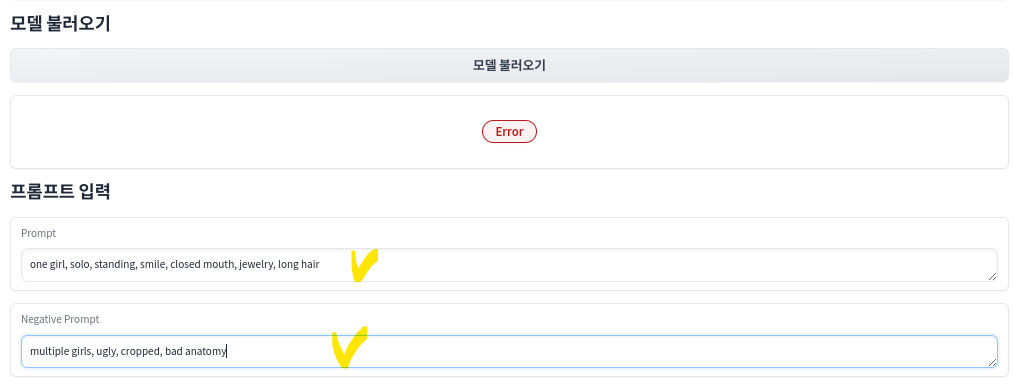